## CRF_to_roughness
* Read in the results of the CRF pixel classification
* Use look-up table to assign roughness
* Interpolate onto model grid

In [1]:
import numpy as np
import pandas as pd
import rasterio # rasterio and OGR don't mix...see rasterio docs
import matplotlib.pyplot as plt
import xarray as xr
import scipy.io as sio
import scipy.signal
from pyproj import Proj, transform
from scipy import interpolate

%matplotlib inline

### Load the image that was classified
This is only needed for the projection and the coordinates.

In [2]:
fn = 'FI_exported.tif'
da = xr.open_rasterio(fn)
da

<xarray.DataArray (band: 1, y: 2795, x: 5128)>
[14332760 values with dtype=uint8]
Coordinates:
  * band     (band) int32 1
  * y        (y) float64 4.516e+06 4.516e+06 4.516e+06 4.516e+06 4.516e+06 ...
  * x        (x) float64 1.692e+05 1.692e+05 1.692e+05 1.692e+05 1.692e+05 ...
Attributes:
    transform:   (0.5, 0.0, 169163.04002845337, 0.0, -0.5, 4516065.419908607,...
    crs:         +init=epsg:26919
    res:         (0.5, 0.5)
    is_tiled:    0
    nodatavals:  (nan,)

### Load the output from the CRF classification of the same image
This was generated by ```int_seg_crf_v1.py``` with user input.

In [3]:
m = sio.loadmat('FI_exported_mres.mat')

In [4]:
np.shape(m['class'])

(2795, 5128)

### Make a dict to convert CRF class to Manning's n.

This is an approximation of Mattocks & Forbes (2008) Table 3.

See also https://github.com/csherwood-usgs/NLCD_to_Roughness/blob/master/NLCD_to_Roughness.ipynb

In [5]:
# These roughness assignments are up for some debate. In particular, MF2008 assign sand = 0.09, but I chose 0.02 (same as water)
# I also put anthropogenic at 0.05, because it is not well classified, and I did not want random big roughness elements.
n = {0: 0.02, 1: 0.045, 2: .02, 3: 0.034, 4: 0.05, 5: 0.05}
m['labels']

array(['sand            ', 'wetland veg     ', 'water           ',
       'dune grass      ', 'woody vegetation', 'anthropogenic   '], 
      dtype='<U16')

In [6]:
# initialize a float array with same shape as class array
nmap = 0.0*np.ones_like(m['class'])
(ni,nj)=np.shape(nmap)
print('Shapes of new np array and DataArray: ',np.shape(m['class']),np.shape(nmap))
print('Print number of rows, columns: ',ni,nj)

# loop through and assign Manning's n value to array using class look-up table
for i in range(ni):
    for j in range(nj):
        nmap[i,j]=n[m['class'][i,j]]
print('\nRoughness values:')
nmap

Shapes of new np array and DataArray:  (2795, 5128) (2795, 5128)
Print number of rows, columns:  2795 5128

Roughness values:


array([[ 0.02 ,  0.02 ,  0.02 , ...,  0.045,  0.045,  0.045],
       [ 0.02 ,  0.02 ,  0.02 , ...,  0.045,  0.045,  0.045],
       [ 0.02 ,  0.02 ,  0.02 , ...,  0.045,  0.045,  0.045],
       ..., 
       [ 0.034,  0.034,  0.05 , ...,  0.02 ,  0.02 ,  0.02 ],
       [ 0.034,  0.034,  0.05 , ...,  0.02 ,  0.02 ,  0.02 ],
       [ 0.034,  0.05 ,  0.05 , ...,  0.02 ,  0.02 ,  0.02 ]])

### Quick plot of the roughness map

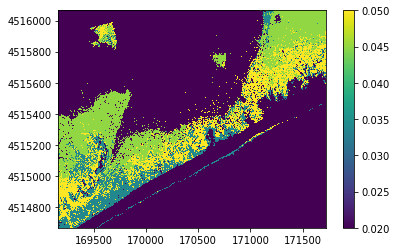

In [7]:
plt.pcolormesh(da['x'].values, da['y'].values, nmap)
plt.colorbar()

### Export utm coords, classes, and roughness values to Matlab file

In [8]:
sio.savemat('nmap.mat',{'utmx': da['x'].values, 'utmy': da['y'].values, 'n': nmap, 'class': m['class']},do_compression=True)

### Interpolate onto COAWST grid

* Probably want to smooth the roughness grid first
* Might have a problem when model grid extends beyond CRF grid
* And need to apply some logic to clean up a few pixels.

In [9]:
# smooth with 2D running median
nmapf = scipy.signal.medfilt2d(nmap, kernel_size=5)

In [10]:
# Import COAWST grid.
dsc = xr.open_dataset('FI_breach_grd50.nc')

# Define the transformation
llProj = Proj(init='epsg:4326') # WGS84 lat/lon
utmProj = Proj(da.crs)

ec,nc = transform(llProj,utmProj,dsc.lon_rho.values,dsc.lat_rho.values)

In [11]:
# Both of these whine about the fact that y decreases, rather than increases...so flip y and nmap
y = np.flipud(da['y'].values)
nmapf = np.flipud(nmapf)
f=interpolate.RegularGridInterpolator((y,da['x'].values), nmapf, method='nearest')

In [17]:
print(np.shape(nc),np.shape(ec))

(439, 480) (439, 480)


In [19]:
# The one-line interpolation call will crash trying to fill model grid points that are outside the domain of the roughness map.
# cnmapi = f((nc,ec)) # does not work here

# Instead, loop through all cells and punt on the ones for which there are not data

# Array for interpolated elevations
cnmapi=np.NaN*np.ones(np.shape(nc))

# this is a slow iteration through all of the points, but allows us to skip ones that are outside
for ij in np.ndindex(cnmapi.shape):
    try:
        cnmapi[ij]=f((nc[ij],ec[ij]))
    except:
        cnmapi[ij]=np.NaN

### Replace NaNs with the default value for sand (0.02)

In [24]:
cnmapi[np.isnan(cnmapi)]= 0.02

### Make a map to see it looks ok

Text(0.5,1,"Manning's $n$")

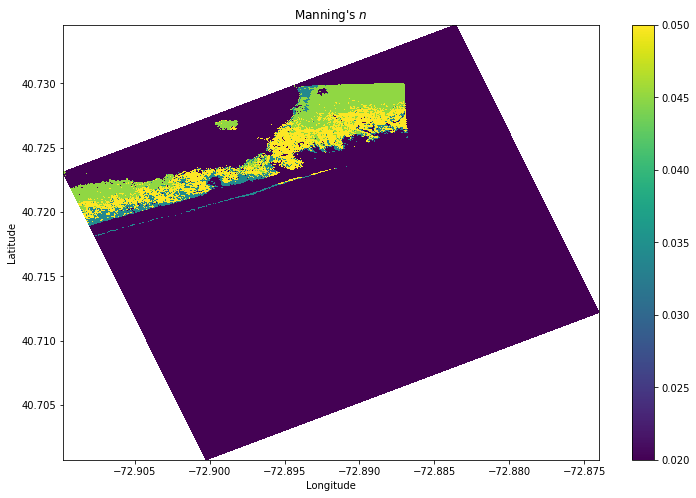

In [25]:
fig = plt.figure(figsize=[12,8])
plt.pcolormesh(dsc.lon_rho.values,dsc.lat_rho.values,cnmapi)
plt.ylabel('Latitude')
plt.xlabel('Longitude')
plt.colorbar()
plt.title('Manning\'s $n$')

### Export as a Matlab .mat file

In [27]:
sio.savemat('FI_breach_grd50_n.mat',{'lon': dsc.lon_rho.values, 'lat': dsc.lat_rho.values, 'n': cnmapi},do_compression=True)